# This script implements a simple baseline-CNN model for the Music Genre Classification task.

In [0]:
# System/zip-handling imports
import os, sys
import zipfile

# Imports image handling
import cv2
import numpy as np
import skimage

# For generating training and test data
import random

# Save training progress
import csv
from datetime import datetime
from shutil import copyfile  # Making copy of this file instance (including param settings used)

#Dependencies for SVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import pandas as pd 

# Get sorted list of training file names:

In [2]:
# Get access to zip-archive
archive = zipfile.ZipFile('../data/spectrograms.zip', 'r')
imgdata = archive.read('spectrograms/spectrogram_0000.png')

files = sorted([f for f in archive.namelist()[1:] if f.startswith('spectrograms/') and f.endswith('.png')])

print(files)

['spectrograms/spectrogram_0000.png', 'spectrograms/spectrogram_0001.png', 'spectrograms/spectrogram_0002.png', 'spectrograms/spectrogram_0003.png', 'spectrograms/spectrogram_0004.png', 'spectrograms/spectrogram_0005.png', 'spectrograms/spectrogram_0006.png', 'spectrograms/spectrogram_0007.png', 'spectrograms/spectrogram_0008.png', 'spectrograms/spectrogram_0009.png', 'spectrograms/spectrogram_0010.png', 'spectrograms/spectrogram_0011.png', 'spectrograms/spectrogram_0012.png', 'spectrograms/spectrogram_0013.png', 'spectrograms/spectrogram_0014.png', 'spectrograms/spectrogram_0015.png', 'spectrograms/spectrogram_0016.png', 'spectrograms/spectrogram_0017.png', 'spectrograms/spectrogram_0018.png', 'spectrograms/spectrogram_0019.png', 'spectrograms/spectrogram_0020.png', 'spectrograms/spectrogram_0021.png', 'spectrograms/spectrogram_0022.png', 'spectrograms/spectrogram_0023.png', 'spectrograms/spectrogram_0024.png', 'spectrograms/spectrogram_0025.png', 'spectrograms/spectrogram_0026.png', 

# JFF: Get a feeling for the nature of the training and evaluation data:

Type of image:
<class 'numpy.ndarray'>
Dimension of a single image file:
(128, 128, 3)


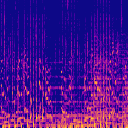

In [3]:
# Interpret image-data as image
from google.colab.patches import cv2_imshow
image = cv2.imdecode(np.frombuffer(imgdata, dtype=np.uint8), 1)

# Print some specs...
print('Type of image:')
print(type(image))
print('Dimension of a single image file:')
print(image.shape)

# Show image visually (press any key in opening window in order to proceed in code...)
cv2.imshow("Image",image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Read in both training and testing data from zip archive:

In [4]:
data_set = []
# Data storage
combined_data = np.empty([1,128,128])
# Read in images & store processed instances
for f_name in files:
    # Get image data from zip file
    zip_img_data = archive.read(f_name)
    image = cv2.imdecode(np.frombuffer(zip_img_data, dtype=np.uint8), 1)
    
    # Normalize image's colors to range [0, 1]
    image = image / 255.0
    
    #cv2.imshow("Normalized Image", image)
    #cv2.waitKey(0)

    # Grayscale image
    gray_image = skimage.color.rgb2gray(image)
    
    #cv2.imshow("Grayscale Image", gray_image)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

    # Store grayscaled image
    combined_data = np.append(combined_data,[gray_image],axis=0)
    
# Remove initial, empty datapoint

combined_data = combined_data[1:,:,:]
print('Done reading in... Shape of data array rnn:')
print(combined_data.shape)
print('Done.')

Done reading in... Shape of data array rnn:
(1000, 128, 128)
Done.


# Read in labels:

In [5]:
labels_path = '/labels.txt'

combined_labels = np.empty([1])

with open(labels_path, 'r') as file:
    for line in file:
        combined_labels = np.append(combined_labels, [int(line)])

# Remove initial, empty datapoint
combined_labels = combined_labels[1:] 
print(combined_labels)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.



# Divide data into train and test data:

------------------------------------------------------
Training data will be contained in:    training_data
Tetsing  data will be contained in:    testing_data

Training labels will be contained in:  training_labels
Tetsing  labels will be contained in:  testing_labels

In [7]:

# Get set of test-indices which indicates the training data points that have to be reserved for training
percentage_test_data = 0.2
population = range(len(combined_labels))
nr_samples = int(percentage_test_data * len(combined_labels))

test_indices = random.sample(population, nr_samples)
test_indices = sorted(test_indices)

print('Nr. test indices: ' + str(len(test_indices)))
print('Test indices: ' + str(test_indices))


# Split data into training- and test data, respectively - Preparation: Create empty arrays in which to later insert data
test_len = len(test_indices)
train_len = len(combined_labels)-len(test_indices)
combined_data_flat = np.empty([train_len + test_len,128*128]) 
test_idx_list_idx = 0
i = 0




#################################################    SVM   ########################################################################
for data_idx in range(len(combined_labels)):
  combined_data_flat[data_idx,:] = combined_data[data_idx, :, :].flatten()

print("Combined Data shape ",combined_data_flat.shape)

###########################################################################################################################




Nr. test indices: 200
Test indices: [0, 1, 3, 4, 7, 9, 10, 16, 24, 31, 38, 45, 46, 51, 56, 58, 59, 62, 71, 79, 83, 91, 94, 110, 114, 121, 126, 150, 153, 158, 173, 174, 177, 178, 182, 183, 184, 188, 192, 195, 196, 204, 205, 207, 210, 229, 230, 233, 234, 240, 244, 249, 251, 262, 267, 272, 279, 280, 282, 284, 291, 293, 308, 321, 329, 331, 332, 343, 347, 356, 359, 363, 369, 372, 381, 384, 394, 400, 406, 408, 410, 414, 421, 422, 423, 426, 434, 441, 445, 451, 454, 456, 458, 461, 466, 467, 476, 477, 482, 485, 487, 492, 495, 496, 513, 514, 521, 526, 528, 535, 536, 542, 543, 546, 547, 556, 559, 575, 578, 579, 583, 604, 617, 623, 625, 631, 633, 635, 641, 650, 653, 654, 655, 656, 659, 664, 671, 683, 693, 702, 705, 708, 715, 716, 720, 725, 744, 746, 747, 751, 761, 764, 769, 774, 777, 780, 784, 792, 793, 795, 796, 799, 800, 805, 813, 818, 819, 822, 823, 824, 826, 828, 839, 844, 848, 852, 860, 863, 882, 901, 906, 910, 918, 919, 923, 929, 934, 935, 941, 943, 948, 952, 956, 957, 959, 973, 974, 975, 97

# PCA and SVM

In [8]:

################################################################################

###############################    SVM    ######################################

################################################################################
ss = StandardScaler()
# run this on our feature matrix
bees_stand = ss.fit_transform(combined_data_flat)

pca = PCA(n_components=500)
# use fit_transform to run PCA on our standardized matrix
bees_pca = ss.fit_transform(bees_stand)
# look at new shape
print('PCA matrix shape is: ', bees_pca.shape)


X = pd.DataFrame(bees_pca)
y = pd.Series(combined_labels)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.3,
                                                    random_state=1234123)

# look at the distrubution of labels in the train set
pd.Series(y_train).value_counts()

svm = SVC(kernel='linear', probability=True, random_state=42)

# fit model
svm.fit(X_train, y_train)


y_pred = svm.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)

PCA matrix shape is:  (1000, 16384)
Model accuracy is:  0.4766666666666667
